In [1]:
suppressMessages({
    library(ggplot2)
    library(animation)
    library(bit64)
    library(data.table)
    library(dplyr)
    library(geosphere)
    library(parallel)
    n_aircraft <- 10
    source("../Old/util.R")
})
mx_speed <- 500
mx_alt <- 50000
cycle_time <- 1800
options(digits = 3)

In [2]:
# Basic preprocessing

files <- list.files()
if(!("first_row_id_ts.Rds" %in% list.files("../"))) {
    ac_data <- fread("../../../../Coding/JFKSamples.csv")
    print(nrow(ac_data))
    ac_data <- ac_data %>% group_by(id, ts) %>% filter(row_number() == 1)
    saveRDS(ac_data, "first_row_id_ts.Rds")
} else {
    ac_data <- readRDS("../first_row_id_ts.Rds")
}
print(nrow(ac_data))
ac_data$ts <- as.numeric(ac_data$ts/1000)

# lag variables - to annotate landing
setDT(ac_data)
setorder(ac_data, id, ts)
ac_data <- get_last_next_cols(ac_data)

[1] 6446292


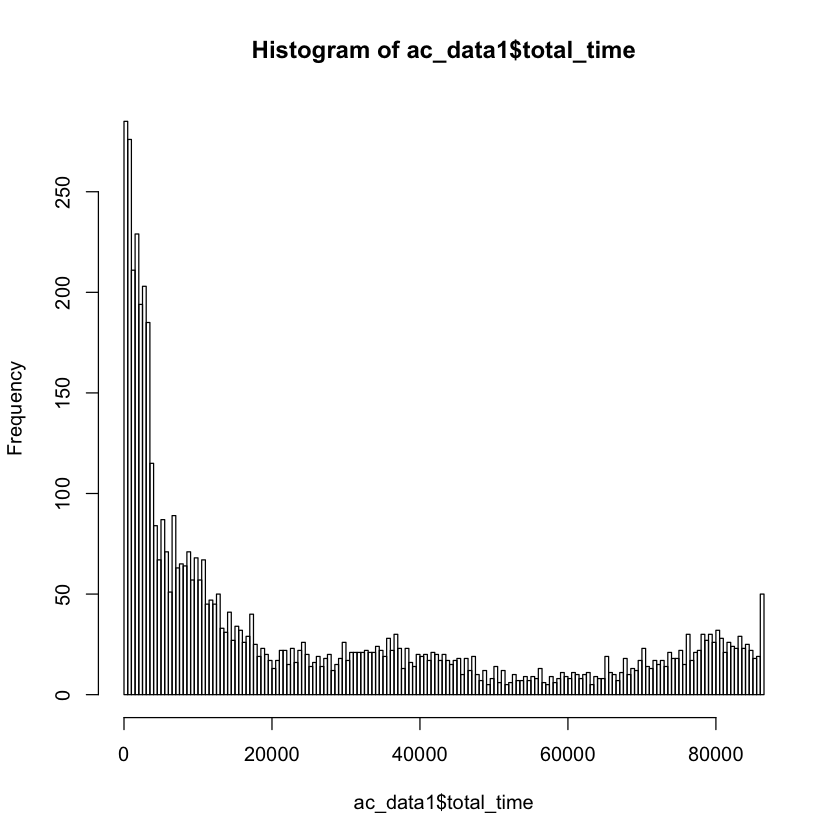

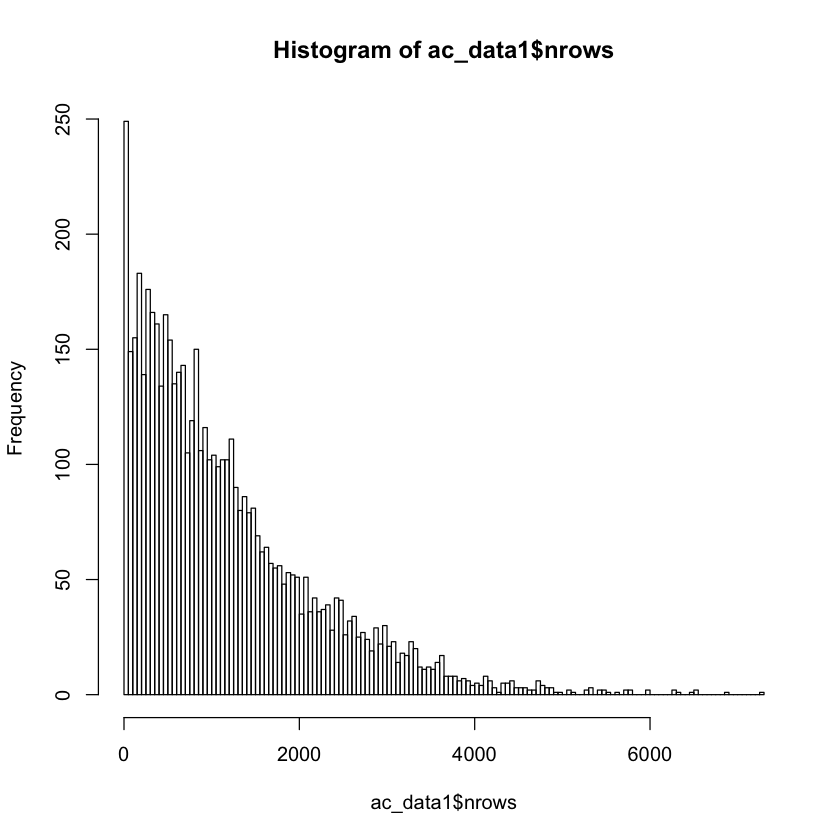

In [3]:
ac_data1 <- unique(ac_data[, c("id", "total_time", "nrows")])
hist(ac_data1$total_time, breaks = 200)
hist(ac_data1$nrows, breaks = 200)

In [4]:
ac_data <- filter_m_min_r_rows(ac_data)
ac_data$last_ts_diff <- as.numeric(ac_data$ts - ac_data$last_ts)
ac_data$next_ts_diff <- as.numeric(ac_data$next_ts - ac_data$ts)
print(nrow(ac_data))

ac_data[, "last_ts_diff" := as.numeric(ts-last_ts), by = id]

# Takeoff, landing cycles and entering, exiting aircraft
ac_data <- get_climb_rate(ac_data)

ac_data <- get_landed(ac_data)

ac_data <- get_entered(ac_data)

ac_data$entered_or_landed <- ac_data$entered | ac_data$landed
ac_data$entered_or_landed[is.na(ac_data$entered_or_landed)] <- F
ac_data[, "num_id" := cumsum(entered_or_landed), by = id]
table(ac_data$num_id)

[1] 6357430



      0       1       2       3       4       5       6       7       8 
3224261 1705028  725355  374890  199081   94946   26619    7064     186 

In [5]:
library(dplyr)
ac_data1 <- data.frame(ac_data) %>% group_by(id) %>% summarize(max_num_id = max(num_id))

In [6]:
cumsum(table(ac_data1$max_num_id)/nrow(ac_data1))

0     1     2     3     4     5     6     7     8 
0.350 0.708 0.832 0.909 0.957 0.986 0.996 1.000 1.000

In [7]:
ac_data[, "max_num_id" := max(num_id), by = id]
# ac_data2 <- ac_data[ac_data$max_num_id == 5, ]

In [8]:
# ac_data2 <- ac_data[ac_data$max_num_id == 5, ]
# ac_data2$exited <- (((ac_data2$last_lon < (-77.8) | ac_data2$last_lon > (-68.2)) &
#     (ac_data2$last_lat < 35.2 | ac_data2$last_lat > 44.8)) | ((ac_data2$lon < (-77.8) &
#     ac_data2$lon > (-68.2)) & (ac_data2$lat < 35.2 | ac_data2$lat > 44.8))) &
#     ac_data2$last_ts_diff > 1800
# ac_data2[ac_data2$landed,]
# landed_idx <- which(ac_data2$landed)
# landed_idx <- unlist(lapply(landed_idx, function(land_idx) c(land_idx - 2, land_idx - 1, land_idx)))
# ac_data2[landed_idx, ]
# diff(ac_data2$ts[ac_data2$landed])
# diff(ac_data2$ts[landed_idx])
# ac_data2$last_ts_diff > 1800

In [9]:
ac_data$id_old <- ac_data$id
ac_data$id <- paste0(ac_data$id, "_", ac_data$num_id)

In [10]:
ac_data <- filter_m_min_r_rows(ac_data)
print(nrow(ac_data))

[1] 6019584


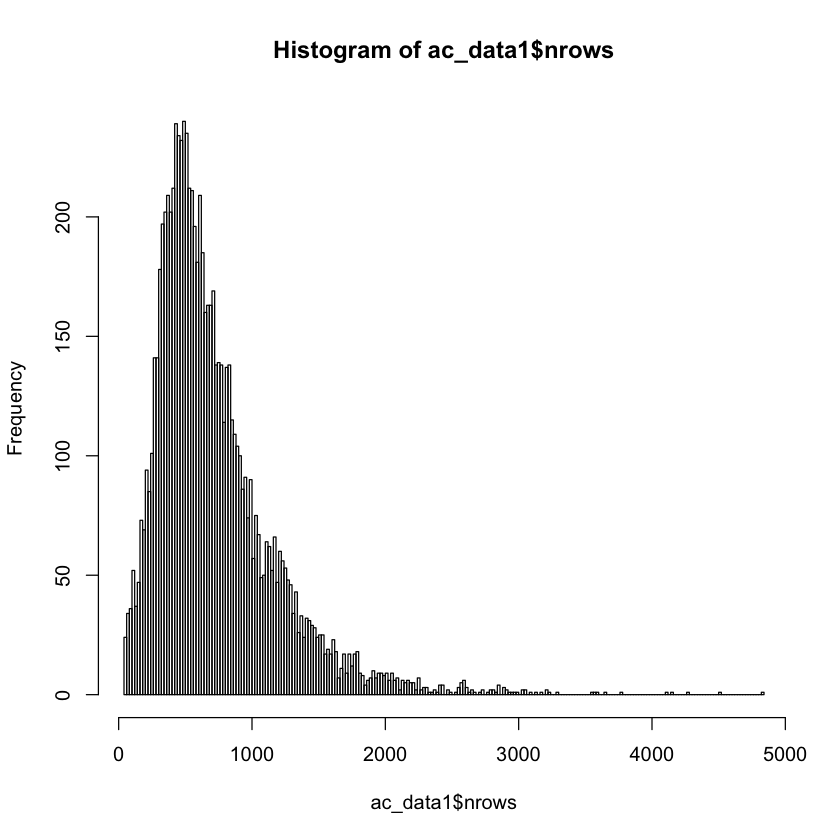

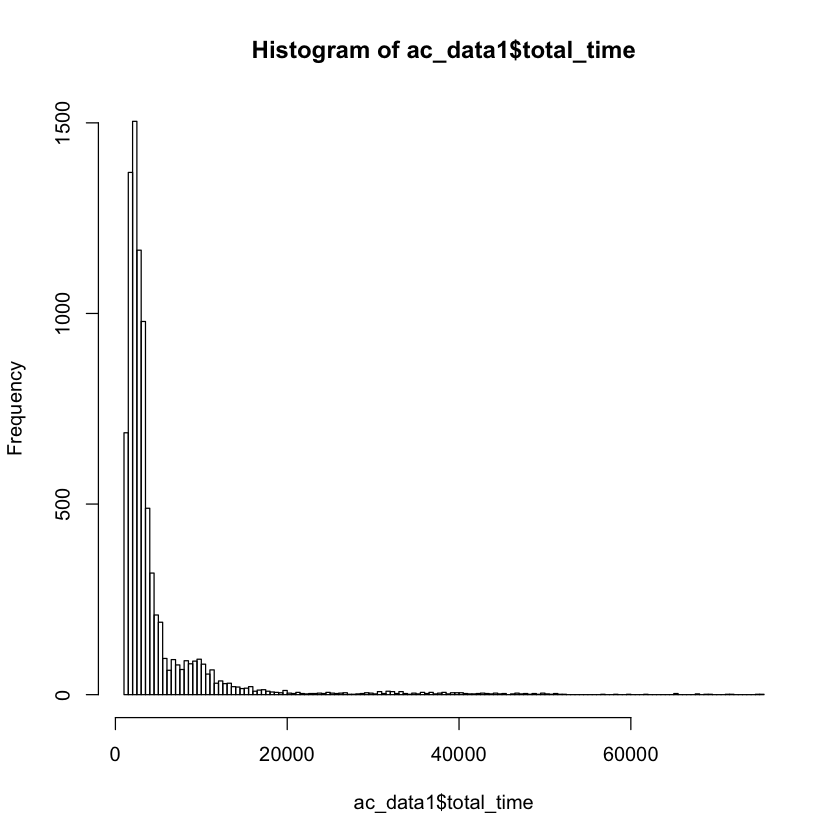

In [11]:
ac_data1 <- unique(ac_data[, c("id", "nrows", "total_time")])
hist(ac_data1$nrows, breaks = 200)
hist(ac_data1$total_time, breaks = 200)

In [12]:
plot_ac_instances(ac_data)

In [13]:
# ac_data <- do.call(rbind, ac_data)
setorder(ac_data, id, ts)
nrow(ac_data)
length(unique(ac_data$id))
# ac_data$landed <- data.table::between(x = ac_data$lon, lower = -74.2, upper = -73.3) &
#   data.table::between(x = ac_data$lat, lower = 40.3, upper = 41) &
# # is the condition on previous lon lat necessary?
#   data.table::between(x = ac_data$last_lon, lower = -74.2, upper = -73.3) &
#   data.table::between(x = ac_data$last_lat, lower = 40.3, upper = 41) &
#   ac_data$last_ts_diff > 1800 &
#     ac_data$altitude <= 1000
ac_data[, "landed" := data.table::between(x = lon[.N], lower = -74.4, upper = -73.3) &
        data.table::between(x = lat[.N], lower = 40.3, upper = 41) & altitude[.N] <= 1000, by = id]
table(ac_data$landed)
# ac_data <- ac_data[ac_data$max_landed == 1, ]
# nrow(ac_data)
# length(unique(ac_data$id))

[1] 6019584

[1] 8385


  FALSE    TRUE 
4676847 1342737 

In [14]:
landed_ac_data <- ac_data[ac_data$landed, ]
length(unique(landed_ac_data$id))

[1] 1853

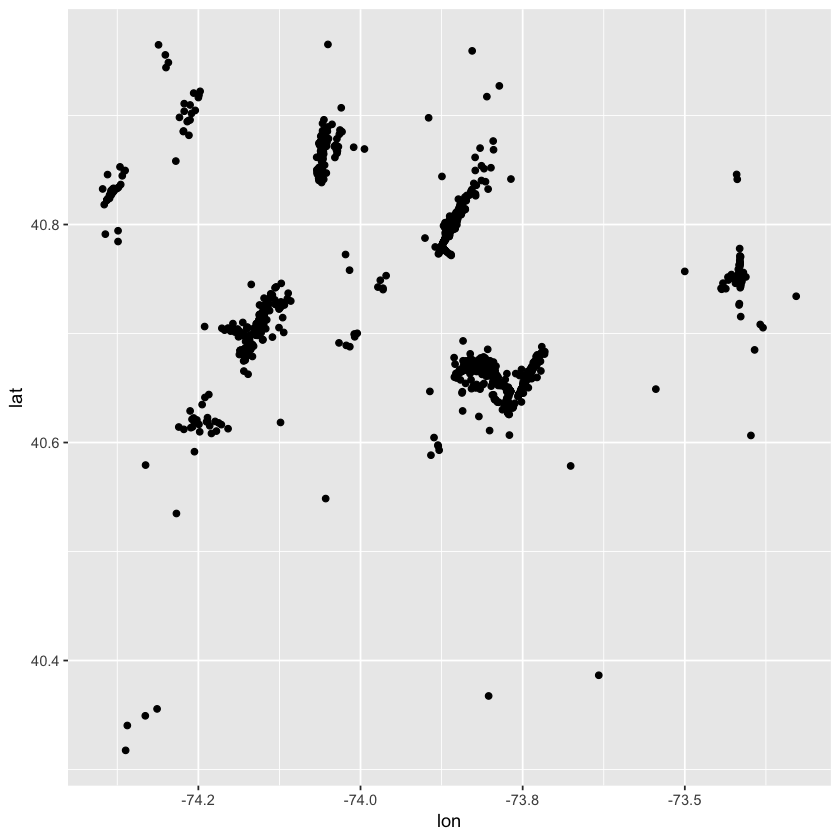

In [15]:
plot_last_points <- function(ac_data) {
    setorder(ac_data, id, ts)
    ac_data <- ac_data[, .SD[.N], by = list(id)]
    p <- ggplot(data = ac_data,
                aes_string(x = "lon", y = "lat", frame = "ts")) +
      geom_point() +
      xlim(c(min(ac_data$lon), max(ac_data$lon))) +
      ylim(c(min(ac_data$lat), max(ac_data$lat))) +
        theme(legend.position = "none")
    p
}
plot_last_points(landed_ac_data)

In [16]:
plot_ac_instances(landed_ac_data, "landed_id")

In [17]:
df1 <- landed_ac_data[landed_ac_data$id == "3C7064_0", ]
df1$last_ts_diff[df1$last_ts_diff > 1800 & df1$quadrant_change]

numeric(0)

In [18]:
saveRDS(landed_ac_data, "landing_subset.Rds")